# GPROF GMI retrieval example

This notebook runs the QRNN GPROF retrieval on a GPROF preprocessor input file and compares the result to the current GPROF algorithm.

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from regn.gprof import InputData
from regn.data.csu.training_data import GPROFDataset
training_data = GPROFDataset("../../data/gprof_gmi_data_00.nc")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from quantnn.plotting import set_style
set_style()


Bad key "mathtext.fallback" on line 203 in
/home/simonpf/src/quantnn/quantnn/data/matplotlib_style.rc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [11]:
from regn.data.csu.retrieval import RetrievalFile
retrieval_file = RetrievalFile("../../data/2A.GCORE.GMI.V7.20190101-S001447-E014719.027510.BIN.gz")
reference_data = retrieval_file.to_xarray_dataset()

In [12]:
from regn.gprof import InputData
normalizer = training_data.normalizer
input_data = InputData("../../data/GMI_190101_027510.pp",
                       normalizer,
                       scans_per_batch=retrieval_file.n_scans)
nn_input = input_data[0].reshape(retrieval_file.n_scans, retrieval_file.n_pixels, -1)
input_data = InputData("../../data/GMI_190101_027510.pp",
                       normalizer,
                       scans_per_batch=8)

In [13]:
from regn.data.csu.preprocessor import PreprocessorFile

file = PreprocessorFile("../../data/GMI_190101_027510.pp")

In [14]:
retrieval_file.get_scan_header(2)["scan_date"]["second"]

array([51], dtype=int16)

In [15]:
retrieval_file.orbit_header["granule_start_date"]["second"]

array([48], dtype=int16)

## Training and input data


This section displays the distributions of input features of the GMI retrieval to ensure that they agree.

### Brightness temperatures

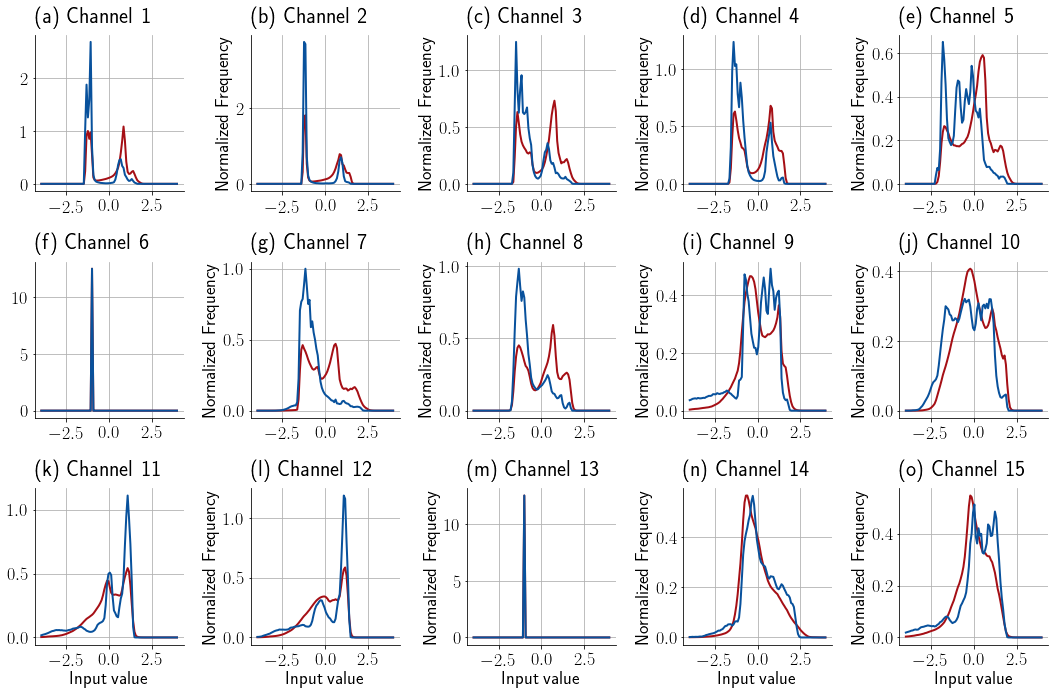

In [16]:
f, axs = plt.subplots(3, 5, figsize=(15, 10))
axs = axs.ravel()

bins = np.linspace(-4, 4, 101)
x = 0.5 * (bins[1:] + bins[:-1])

for i in range(15):
    ax = axs[i]
    
    y, _ = np.histogram(training_data.x[:, i], bins=bins, density=True)
    ax.plot(x, y)
    y, _ = np.histogram(nn_input[:, :, i].ravel(), bins=bins, density=True)
    ax.plot(x, y)
    
    ax.set_title(f"({chr(ord('a') + i)}) Channel {i + 1}", loc="left")
    if (i >= 10):
        ax.set_xlabel("Input value")
    if (i % 5):
        ax.set_ylabel("Normalized Frequency")
    
plt.tight_layout()

### Ancillary data

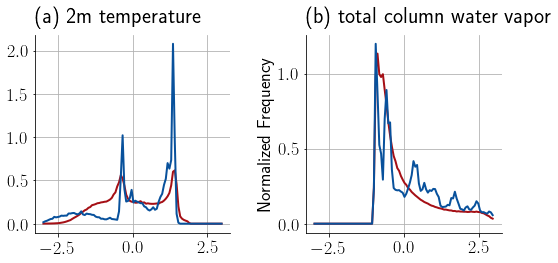

In [17]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel()
titles = ["2m temperature", "total column water vapor"]
bins = np.linspace(-3, 3, 101)
x = 0.5 * (bins[1:] + bins[:-1])

for i in range(2):
    ax = axs[i]
    
    y, _ = np.histogram(training_data.x[:, 15 + i], bins=bins, density=True)
    ax.plot(x, y)
    y, _ = np.histogram(nn_input[:, :, 15 + i], bins=bins, density=True)
    ax.plot(x, y)
    
    ax.set_title(f"({chr(ord('a') + i)}) {titles[i]}", loc="left")
    if (i >= 10):
        ax.set_xlabel("Input value")
    if (i % 5):
        ax.set_ylabel("Normalized Frequency")
    
plt.tight_layout()

### Categorical data

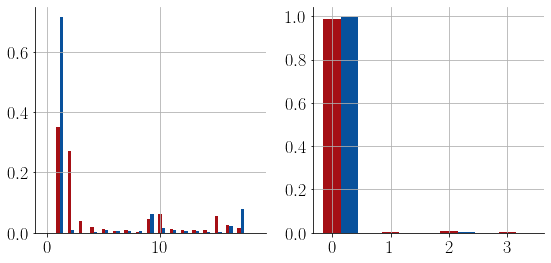

In [18]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel()
titles = ["surface type", "air mass type"]
x = 0.5 * (bins[1:] + bins[:-1])

#
# Surface type
#

bins = np.linspace(-0.5, 19.5, 20)
x = np.arange(19)

types = np.where(training_data.x[:, 17:36])[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[0].bar(x, y, width=0.3)

types = np.where(nn_input[:, :, 17:36].reshape(-1, 19))[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[0].bar(x + 0.3, y, width=0.3)


bins = np.linspace(-0.5, 3.5, 5)
x = np.arange(4)

types = np.where(training_data.x[:, 36:])[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[1].bar(x, y, width=0.3)

types = np.where(nn_input[:, :, 36:].reshape(-1, 4))[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[1].bar(x + 0.3, y, width=0.3)

plt.tight_layout()

## Running the retrieval

In [19]:
from quantnn import QRNN
qrnn = QRNN.load("../../models/qrnn_gmi_24_512_relu.pt")

In [20]:
results = input_data.run_retrieval(qrnn)

In [21]:
input_data.write_retrieval_results(".", results)

In [22]:
rm 2A.QCORE.GMI.V7.20190101-S001448-E014720.027510.BIN.gz

In [23]:
!gzip 2A.QCORE.GMI.V7.20190101-S001448-E014720.027510.BIN

In [24]:
results = RetrievalFile("2A.QCORE.GMI.V7.20190101-S001448-E014720.027510.BIN.gz").to_xarray_dataset()

## GPM combined

In [27]:
from datetime import datetime
from pansat.products.satellite.gpm import l2b_gpm_cmb
t_0 = datetime(2019, 1, 1, 0, 15)
t_1 = datetime(2019, 1, 1, 0, 15)
files = l2b_gpm_cmb.download(t_0, t_1)

Please enter your pansat user password:
········


In [28]:
from pansat.formats.hdf5 import File
file = File(files[0])
file["Swath"].keys()
lats_cmb = file["Swath/Latitude"][:]
lons_cmb = file["Swath/Longitude"][:]
precip_cmb = file["Swath/surfacePrecipRate"][:]

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


## Comparison to GPROF

In [78]:
precip_gprof = reference_data["surface_precip"]
lats_gprof = reference_data["latitude"]
lons_gprof = reference_data["longitude"]
mask = precip_gprof < 0.0

In [79]:
precip_qrnn = results["surface_precip"]
lats_qrnn = input_data.data["latitude"]
lons_qrnn = input_data.data["longitude"]
precip_qrnn.data[mask] = np.nan

In [80]:
from pyresample import SwathDefinition
from pyresample import kd_tree
x = np.linspace(-180, 180, 500)
y = np.linspace(-90, 90, 250)
x, y = np.meshgrid(x, y)

target = SwathDefinition(x, y)
source = SwathDefinition(lons_gprof.data, lats_gprof.data)

result_gprof = kd_tree.resample_nearest(source,
                                  precip_gprof.data,
                                  target,
                                  radius_of_influence=10000,
                                  fill_value=np.nan,
                                  epsilon=0.5)
result_qrnn = kd_tree.resample_nearest(source,
                                  precip_qrnn.data,
                                  target,
                                  radius_of_influence=10000,
                                  fill_value=np.nan,
                                  epsilon=0.5)

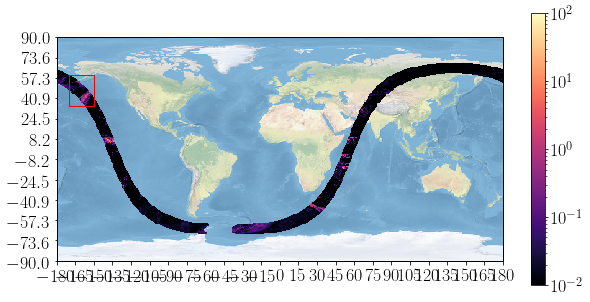

In [83]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

norm = LogNorm(1e-2, 1e2)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
m = ax.pcolormesh(x, y, result_gprof, norm=norm)
ax.stock_img()
ax.set_xticks(np.linspace(-180, 180, 25))
ax.set_yticks(np.linspace(-90, 90, 12))

lat_min = 35.0
lat_max = 60.0
lon_min = -170
lon_max = -150

width = lon_max - lon_min
height = lat_max - lat_min
r = Rectangle([lon_min, lat_min],
              width=width,
              height=height,
              edgecolor="red",
              facecolor=[0.0, 0.0, 0.0, 0.0])
ax.add_patch(r)
plt.colorbar(m)

In [84]:
mask = (lats_gprof > lat_min) * (lats_gprof <= lat_max) * (lons_gprof > lon_min) * (lons_gprof <= lon_max)
i_start, i_end = np.where(np.any(mask, axis=1))[0][[0, -1]]

In [85]:
mask = (lats_cmb > lat_min) * (lats_cmb <= lat_max) * (lons_cmb > lon_min) * (lons_cmb <= lon_max)
i_start_cmb, i_end_cmb = np.where(np.any(mask, axis=1))[0][[0, -1]]

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1583: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  warnings.warn("The colormap's 'bad' has been set, but "
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1583: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  warnings.warn("The colormap's 'bad' has been set, but "
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


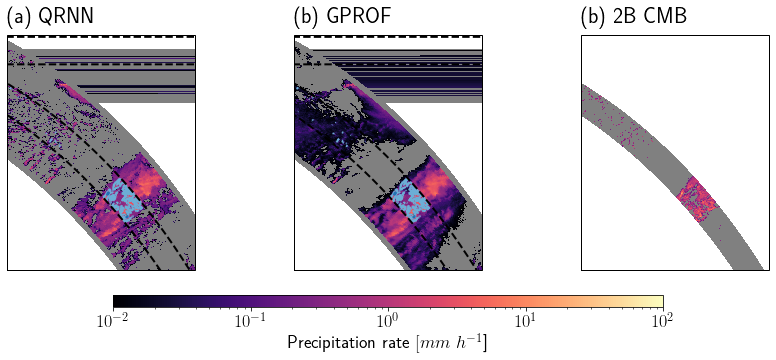

In [86]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm import get_cmap
from copy import copy
plt.figure(figsize=(15,5))
gs = GridSpec(2, 6, height_ratios=[1.0, 0.05])
norm = LogNorm(1e-2, 1e2)

cmap = copy(get_cmap())
cmap.set_under("grey")
cmap.set_bad("grey")

x_cmb = lons_cmb[i_start_cmb:i_end_cmb, :]
y_cmb = lats_cmb[i_start_cmb:i_end_cmb, :]
z_cmb = precip_cmb[i_start_cmb:i_end_cmb, :]

ax = plt.subplot(gs[0, 0:2], projection=ccrs.PlateCarree())

x = lons_qrnn[i_start:i_end, :]
y = lats_qrnn[i_start:i_end, :]
z = precip_qrnn[i_start:i_end, :]
ax.pcolormesh(x, y, z, norm=norm, cmap=cmap)
ax.contour(x_cmb, y_cmb, z_cmb, norm=norm, cmap="Blues")
ax.plot(lons_cmb[:, [0, -1]], lats_cmb[:, [0, -1]], c="k", ls="--")
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_title("(a) QRNN", loc="left")

ax = plt.subplot(gs[0, 2:4], projection=ccrs.PlateCarree())

x = lons_gprof[i_start:i_end, :]
y = lats_gprof[i_start:i_end, :]
z = precip_gprof[i_start:i_end, :]
ax.pcolormesh(x, y, z, norm=norm, cmap=cmap)
ax.contour(x_cmb, y_cmb, z_cmb, norm=norm, cmap="Blues")
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.plot(lons_cmb[:, [0, -1]], lats_cmb[:, [0, -1]], c="k", ls="--")
ax.set_title("(b) GPROF", loc="left")

ax = plt.subplot(gs[0, 4:6], projection=ccrs.PlateCarree())

x = lons_cmb[i_start_cmb:i_end_cmb, :]
y = lats_cmb[i_start_cmb:i_end_cmb, :]
z = precip_cmb[i_start_cmb:i_end_cmb, :]
m = ax.pcolormesh(x, y, z, norm=norm, cmap=cmap)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_title("(b) 2B CMB", loc="left")

ax = plt.subplot(gs[1, 1:5])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Precipitation rate $[mm\ h^{-1}$]")

Text(0.5, 0, 'QRNN precip. rate [$mm\\ h^{-1}$]')

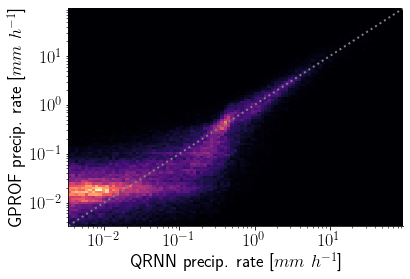

In [36]:
bins = np.logspace(-2.5, 2, 101)
x = 0.5 * (bins[1:] + bins[:-1])
img, _, _ = np.histogram2d(precip_qrnn.data.ravel(), precip_gprof.data.ravel(), bins=bins)
plt.pcolormesh(x, x, img.T)
plt.xscale("log")
plt.yscale("log")
plt.plot(x, x, c="grey", ls=":")
plt.ylabel("GPROF precip. rate [$mm\ h^{-1}$]")
plt.xlabel("QRNN precip. rate [$mm\ h^{-1}$]")